# AIOps anomaly detection with detectors

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do anomaly detection for 1-D data using Chronos's dbscan detector, autoencoder detector and threshold detector.

For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction <a href="https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md" target="_blank">here</a>. In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>.

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_drop_ts_and_len(df, target_col="cpu_usage", allow_missing_num=3):
    """
    get start index which with consecutive missing num larger than allow_missing_num
    """
    missing_num = df[target_col].isnull().astype(int).groupby(df[target_col].notnull().astype(int).cumsum()).sum()
    missing_num = missing_num[missing_num > 0]
    drop_ts = df.iloc[(missing_num.index + missing_num.cumsum() - missing_num).values].index
    drop_ts = drop_ts[missing_num > allow_missing_num]
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_len = drop_missing_num.values
    return drop_ts, drop_len

In [2]:
def rm_missing_day(start_dts, missing_lens, df):
    """
    drop days with consecutive missing values.
    If consecutive missing values across day, we remove the data for an extra hour.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time.replace(hour=0, minute=0, second=0)
        start_day_end = start + pd.Timedelta(hours=24)
        start_day_end = start_day_end - pd.Timedelta(minutes=1)
        end_time = start_time + l*pd.Timedelta(minutes=1)
        if start_day_end < end_time:
            end = end_time + pd.Timedelta(hours=1)
        else:
            end = start_day_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
def get_result_df(df, ano_index):
    """
    Add anomalies value to dataframe.
    """
    result_df = df.copy()
    result_df['anomalies'] = 0
    result_df.loc[df.index[ano_index], 'anomalies'] = 1
    result_df['anomalies'] = result_df['anomalies'] > 0
    return result_df

In [4]:
def plot_anomalies_value(date, y, anomalies):
    """
    plot the anomalies value
    """
    fig, axs = plt.subplots(figsize=(16,6))
    
    axs.plot(date, y, color='blue', label='y')
    axs.scatter(date[anomalies].tolist(), y[anomalies], color='red', label='anomalies value')
    axs.set_title('the anomalies value')
    
    plt.xlabel('datetime')
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe.Steps are as below:
* First, download the raw data <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>. Or run the script `get_data.sh` to download the raw data.It will download the resource usage of each machine from m_1932 to m_2085. 
* Second, run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932. Or run `extract_data.sh`.We use machine 1932 as an example in this notebook.You can choose any machines in the similar way.
* Finally, use pandas to load `m_1932.csv` into a dataframe as shown below.

In [5]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage","mem_usage"])

Below are some example records of the data

In [7]:
df_1932.head()

,time_step,cpu_usage,mem_usage
0,386640,41,92
1,386670,43,92
2,386690,44,92
3,386800,46,92
4,386930,44,93


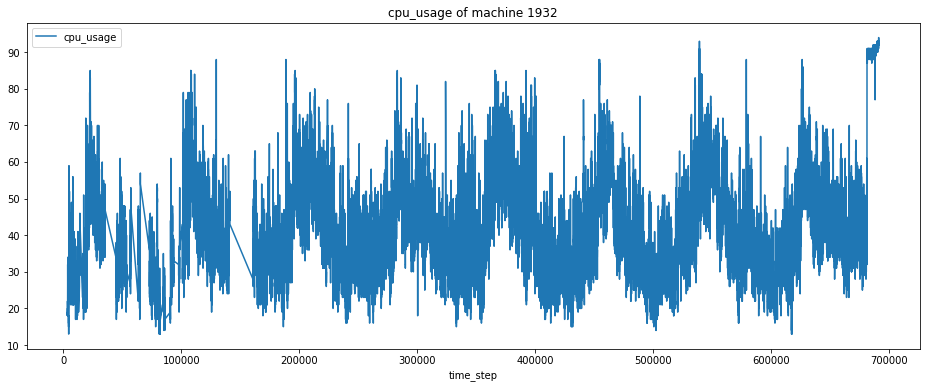

In [8]:
df_1932.sort_values(by="time_step").plot(y="cpu_usage", x="time_step", figsize=(16,6),title="cpu_usage of machine 1932")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the machine_usage data, the pre-processing contains 2 parts:
1. Change the time unit from seconds to minutes, which is calculated by averaging `cpu_usage` within the minutes.
2. Check missing values and handle missing data(fill or drop)

Change the time unit to minute.

In [9]:
df_1932["ts_min"] = df_1932["time_step"]//60

Calculate the average of cpu_usage in the same time and draw the line chart.

In [10]:
resampled_df = df_1932.groupby("ts_min").agg({"cpu_usage":"mean"})

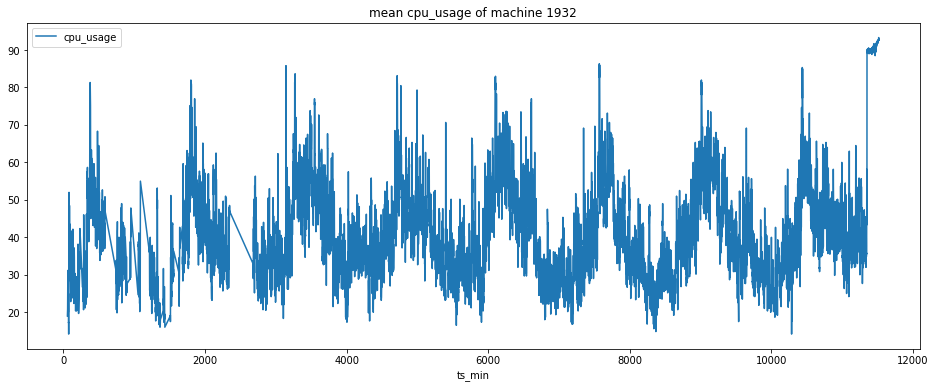

In [11]:
resampled_df.plot(figsize=(16,6),title="mean cpu_usage of machine 1932")

We need datetime information to generate related features,so re-adjust time series.

In [12]:
resampled_df.index = pd.to_datetime(resampled_df.index, unit='m', origin=pd.Timestamp('2018-01-01'))

Ensure the time interval of dataframe is the same.

In [13]:
full_idx = pd.date_range(start=resampled_df.index.min(), end=resampled_df.index.max(),freq='T')
resampled_df = resampled_df.reindex(full_idx)

In [14]:
resampled_df.head()

,cpu_usage
2018-01-01 00:56:00,19.000000
2018-01-01 00:57:00,19.666667
2018-01-01 00:58:00,19.666667
2018-01-01 00:59:00,20.833333
2018-01-01 01:00:00,25.666667


Here, we drop day with more than 3 consecutive missing values and fill other missing values remained.

In [15]:
drop_ts,drop_len = get_drop_ts_and_len(resampled_df,allow_missing_num=3)
df = rm_missing_day(drop_ts, drop_len,resampled_df)

In [16]:
df.head()

,cpu_usage
2018-01-03 00:00:00,29.666667
2018-01-03 00:01:00,33.000000
2018-01-03 00:02:00,37.833333
2018-01-03 00:03:00,34.666667
2018-01-03 00:04:00,37.166667


In [17]:
print("no. of n/a values:")
print(df.isna().sum())

no. of n/a values:
cpu_usage    21
dtype: int64


In [18]:
df.ffill(inplace=True)

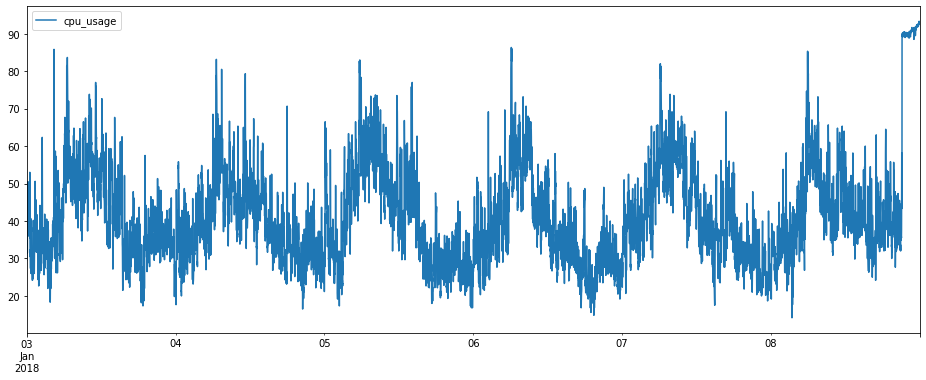

In [19]:
df.plot(figsize=(16,6))

## Anomaly Detection by DBScan Detector

In [20]:
from zoo.chronos.model.anomaly import DBScanDetector

ad = DBScanDetector(eps=0.1, min_samples=6)
ad.fit(df['cpu_usage'].to_numpy())

In [21]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0. 0. 0. ... 1. 1. 1.]
The anomaly indexes are: [ 263  368  386  387  388  389  390  391  392  393  394  395  396  403
  404  452  568  605  610  611  614  624  664  665  666  667  668  669
  670  671  725  726  850 1108 1124 1128 1428 1444 1445 1801 1829 1830
 1831 1832 1833 1834 1835 1836 1837 1838 1846 1851 1852 1870 1885 1886
 2096 2112 2113 2114 2195 2518 2519 2669 2670 2678 3024 3215 3216 3217
 3218 3219 3220 3221 3222 3223 3224 3225 3226 3233 3234 3235 3236 3244
 3259 3260 3279 3280 3285 3304 3324 3326 3327 3328 3329 3332 3333 3359
 3360 3361 3373 3388 3394 3399 3400 3412 3422 3423 3476 3580 3581 3582
 3584 3585 3721 3729 3918 3922 4074 4293 4302 4312 4466 4625 4676 4683
 4684 4685 4686 4687 4688 4689 4690 4691 4692 4693 4694 4708 4726 4727
 4728 4756 4757 4766 4767 4801 4802 4830 4831 4832 4857 4861 5362 5363
 5364 5453 5456 5458 5459 5460 5465 5472 5481 5485 5487 5492 6094 6104
 6126 6127 6128 6129 6130 6131 6132 6133 6134 6135 6136 6137 6138 6139
 614

Draw anomalies in line chart.

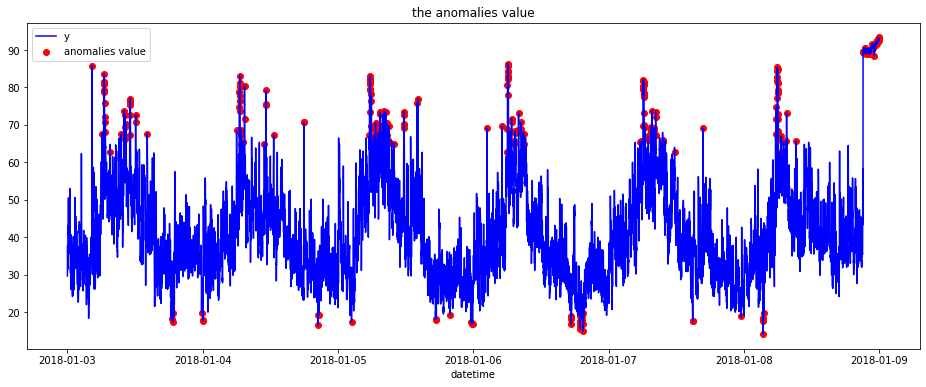

In [22]:
result_df = get_result_df(df, anomaly_indexes)
plot_anomalies_value(result_df.index, result_df.cpu_usage, result_df.anomalies)

## Anomaly Detection by AutoEncoder Detector

In [23]:
from zoo.chronos.model.anomaly import AEDetector

ad = AEDetector(roll_len=6, ratio=0.05)
ad.fit(df['cpu_usage'].to_numpy())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0.34764183 0.36148527 0.30011392 ... 0.92975634 0.8490277  0.8509361 ]
The anomaly indexes are: [5718 4062 5473 5513 5409 2674 5505 5476 4306 5477 4317 1494  393 4314
 5475 1830 5407 5742 1495 5717  226 1113 4300 5431 5727 5726 7175 7198
 5467 4005 1114 7107 3007 4003 5502 5433 5512 5500 5517 7162 5719 7406
 4063 7202 5744 2677 1445 7105 6650 5408 1832 1109 2673 7411 4307 1836
 5435 4299 7111 5451 5434 5743 5516 5471 1496 3006 5498 2667 5449 6651
 1107 1104 2679 2676 6132 5427 4313 4298 4002 5423 5501 6659 4304 1831
 2666 7112 5469 7163 4004 1444 3916 1133 5357 7110 7201 5426 3224 5466
 4309 7408 6131 5739 6127 1126 1123 7113 7108 3024 6135 4311 5499 1105
 5436 3925 5472 5424 2678 7164 5429 5496 1122 5495 2668 2670 3223 7173
 7109 5480 7402 7174 7200 5428 1127 7171 7165 1121 6133 6134 7166 4308
 5432 7401 1833 1835 4301 7170  390 7203 3924 7199 4303 6129 1129 5482
 7204 6128 7172 6652 1132 1108 3926  387  386 1106 1125 5369 5494 3220
 7557 3923 6658 1128  391 7

Draw anomalies in line chart.

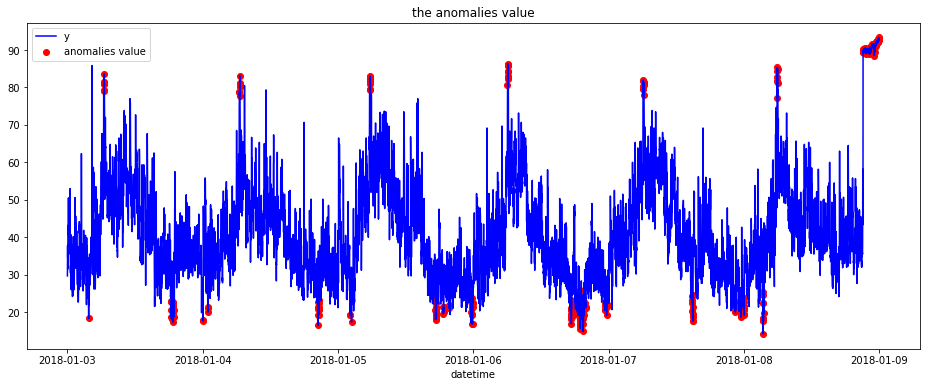

In [25]:
result_df = get_result_df(df, anomaly_indexes)
plot_anomalies_value(result_df.index, result_df.cpu_usage, result_df.anomalies)

## Anomaly Detection by Threshold Detector

In [26]:
from zoo.chronos.model.anomaly import ThresholdDetector

thd=ThresholdDetector()
thd.set_params(threshold=(20, 80))
thd.fit(df['cpu_usage'].to_numpy())

In [27]:
anomaly_scores = thd.score()
anomaly_indexes = thd.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0. 0. 0. ... 1. 1. 1.]
The anomaly indexes are: [6656, 6657, 7168, 7169, 8548, 8549, 8550, 8551, 8552, 8630, 8554, 7199, 8555, 7204, 8556, 8631, 8559, 8562, 4684, 4685, 4686, 4687, 4688, 4689, 1106, 4690, 4692, 1108, 4691, 4693, 8564, 1124, 8568, 1128, 8569, 5739, 1132, 2669, 2670, 8570, 8571, 2678, 8572, 8573, 8574, 8614, 8575, 8576, 3216, 3217, 3218, 3219, 8577, 3221, 3222, 8578, 3224, 3225, 8579, 8580, 8581, 8582, 8584, 8586, 8587, 4293, 4302, 4303, 8589, 4308, 4312, 7167, 226, 227, 8594, 7403, 7404, 7405, 5361, 5362, 5363, 5364, 5365, 5366, 7409, 7411, 8623, 8599, 263, 8601, 8603, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 1834, 1835, 1836, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 5432, 8501, 8502, 8503, 5436, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 5453, 5454, 3918, 5456, 5457, 5458, 5459, 5460,

Draw anomalies in line chart.

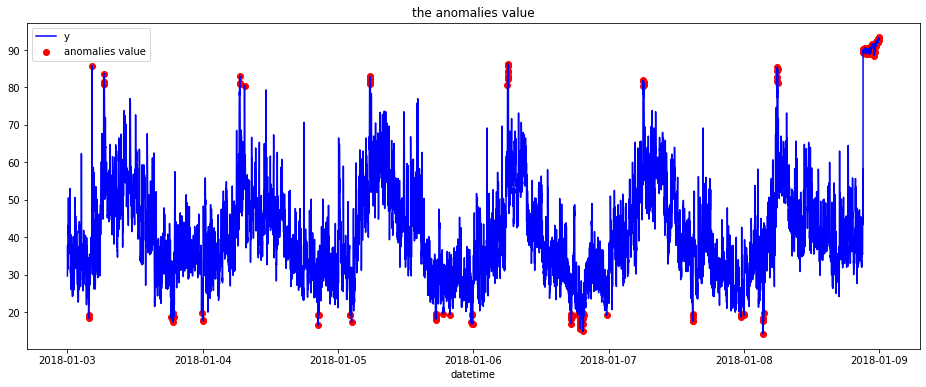

In [28]:
result_df = get_result_df(df, anomaly_indexes)
plot_anomalies_value(result_df.index, result_df.cpu_usage, result_df.anomalies)